In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

In [2]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read("klavir.wav")
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
                               # but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

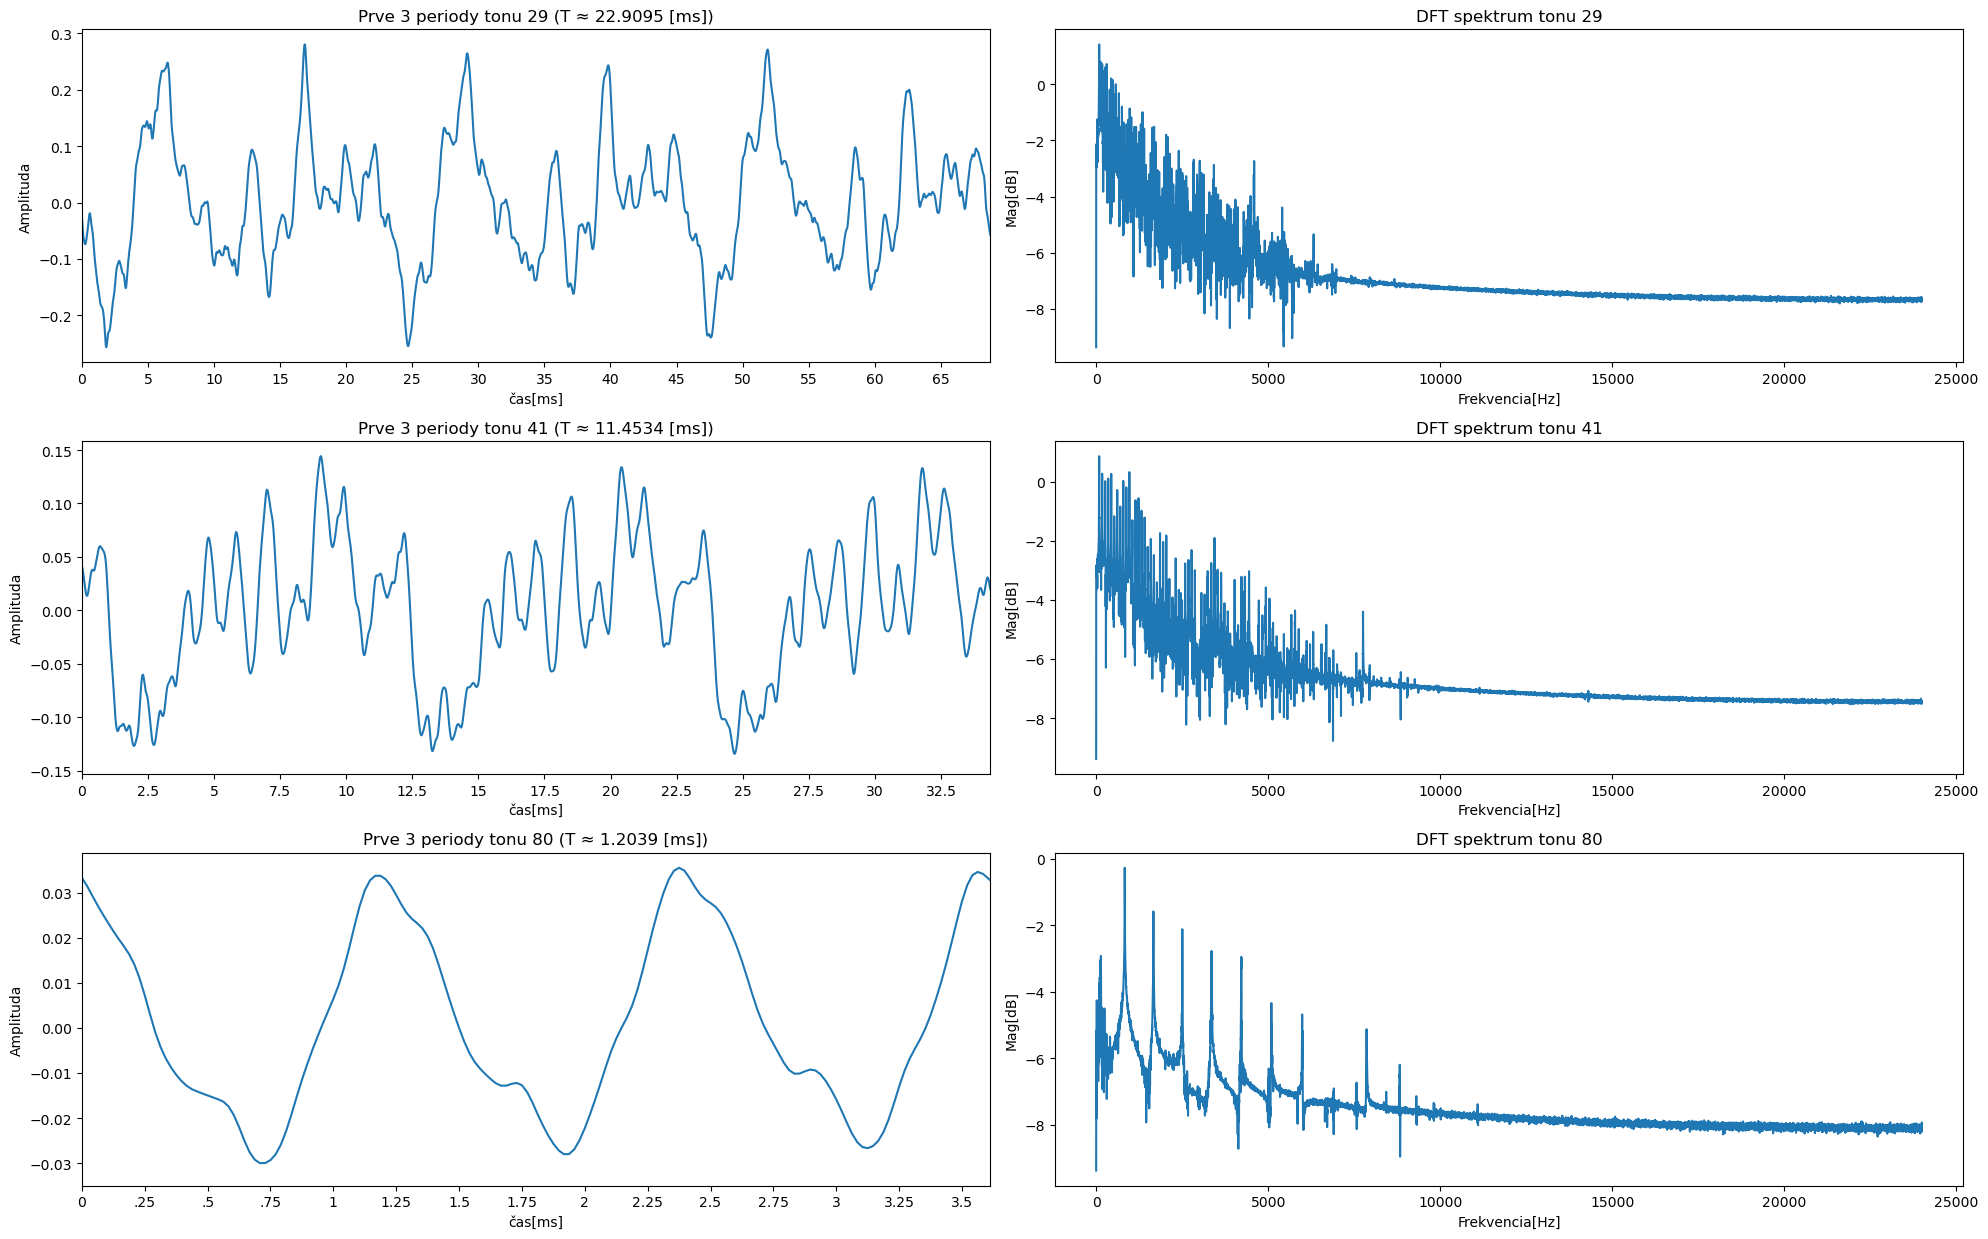

In [59]:
def plot_SIGNAL(r, c, midifreq, tone):
    T = 1 / midifreq
    segment = np.arange(xall[tone].size) / Fs
    #29; 43.65Hz
    #T = 1/43.65 = 0.0229095s*1000 = 22.9095ms
    #3*(T*Fs) ;pocet vzorkov na 3 periody
    ax[r][c].set_title('Prve 3 periody tonu %d (T ≈ %1.4f [ms])' % (tone, T*1000))
    ax[r][c].set_xlabel('čas[ms]')
    if r==0:
        ax[r][c].set_xticks((0.00, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065), 
                            ("0", "5", "10", "15", "20", "25", "30", "35", "40", "45", "50", "55", "60", "65"))
    if r==1:
        ax[r][c].set_xticks((0.000, 0.0025,0.005, 0.0075, 0.010, 0.0125, 0.015, 0.0175, 0.020, 0.0225, 0.025, 0.0275, 0.030, 0.0325), 
                            ("0", "2.5", "5", "7.5", "10", "12.5", "15", "17.5", "20", "22.5", "25", "27.5", "30", "32.5"))
    if r==2:
        ax[r][c].set_xticks((0.0000, 0.00025, 0.0005, 0.00075, 0.0010, 0.00125, 0.0015, 0.00175, 0.0020, 0.00225, 0.0025, 0.00275, 0.0030, 0.00325, 0.0035), 
                            ("0", ".25", ".5", ".75", "1", "1.25", "1.5", "1.75", "2", "2.25", "2.5", "2.75", "3", "3.25", "3.5"))
        
    ax[r][c].set_ylabel('Amplituda')
    ax[r][c].set_xlim(0, T*3)
    ax[r][c].plot(segment, xall[tone])
    
def plot_PSD(r, c, tone):
    DFT = np.fft.fft(xall[tone])
    #PSD = np.log10((np.abs(DFT)**2) + 1e-5) #np.log10((1/xall[tone].size) * (np.abs(segmentDFT)**2) + 1e-10)
    PSD = np.log10((((np.abs(DFT)**2) + 1e-5) * (1/xall[tone].size)))
    PSDHalf = PSD[:PSD.size // 2]
    Fk = np.arange(PSDHalf.size) * (Fs / xall[tone].size)
    ax[r][c].set_title('DFT spektrum tonu %d' % tone)
    ax[r][c].set_xlabel('Frekvencia[Hz]')
    ax[r][c].set_ylabel('Mag[dB]')
    ax[r][c].plot(Fk, PSDHalf)

_, ax = plt.subplots(3, 2, figsize=(20, 12.5))

############################ TÓN 29 ############################
plot_SIGNAL(0, 0, 43.65, 29)
plot_PSD(0, 1, 29)

############################ TÓN 41 ############################
plot_SIGNAL(1, 0, 87.31, 41)
plot_PSD(1, 1, 41)

############################ TÓN 80 ############################
plot_SIGNAL(2, 0, 830.61, 80)
plot_PSD(2, 1, 80)

plt.tight_layout()

sf.write('a_orig.wav', xall[29], 48000)
sf.write('b_orig.wav', xall[41], 48000)
sf.write('c_orig.wav', xall[80], 48000)

In [5]:
############## VYPOCET POMOCI AUTOKOLERACE (DO TONU 43) ############## 
print("vypocet zakladni frekvence f0 pomoci autokolerace (do 70. tonu)")
for tone in range(MIDIFROM, 71):
    corr = np.correlate(xall[tone],xall[tone], "full")
    corr = corr[int(len(corr)/2):] #staci len druha polovica autokoleracie
    start = np.argmax(corr<0) #najdem vzdialenost prvej hodnoty pod osou x - inak by funkcia np.argmax vzdy bola rovna 0
    peak_max = np.max(corr[start:]) #najdem maximalnu hodnotu koleracie od tejto vzdialenosti
    peaks = signal.find_peaks(corr[start:], height=0) #pomocou find_peaks najdem vzdialenosti dalsich vrcholov signalu, 
                                                      #find_peaks vrati dvojrozmerne pole, v prvom budu indexy vrcholov
                                                      #v druhom bude dict 'peak_heights' obsahujuci hodnotu na kazdom vrchole 
    peak_distance = peaks[0][np.where(peaks[1]["peak_heights"] == peak_max)[0][0]] #najdem, na ktorom indexe sa v peak_heights nachadza maximalna hodnota
                                                                                   #na rovnakom indexe sa bude v datach vzdialenosti nachadzat vzdialenost
                                                                                   #viz. scipy.signal.find_peaks
    freq = Fs/(peak_distance+start) 
    print("f0 tonu %d: %1.2f" % (tone, freq))   

    
############## VYPOCET POMOCI DFT (OD 43 DO 108) ##############
print("\nvypocet zakladni frekvence f0 pomoci DFT (od tonu 71)")
for tone in range(71, MIDITO+1):
    DFT = np.fft.fft(xall[tone])
    DFT = np.abs(DFT)
    DFTHalf = DFT[:DFT.size // 2]
    Fk = np.arange(0, DFTHalf.size) * (Fs / (xall[tone].size))
    peaks = signal.find_peaks(DFTHalf, height=0) #parameter height vytvori data s hodnotami magnitud
    max_mag = np.max(DFTHalf) #zistim najvacsiu hodnotu magnitudy v DFT
    fundamental_freq = peaks[0][np.where(peaks[1]["peak_heights"] == max_mag)[0][0]] * 2
    print("f0 tonu %d: %d" % (tone, fundamental_freq))
        

vypocet zakladni frekvence f0 pomoci autokolerace (do 70. tonu)
f0 tonu 24: 32.81
f0 tonu 25: 34.76
f0 tonu 26: 36.84
f0 tonu 27: 39.02
f0 tonu 28: 41.34
f0 tonu 29: 43.80
f0 tonu 30: 46.42
f0 tonu 31: 49.18
f0 tonu 32: 52.12
f0 tonu 33: 55.17
f0 tonu 34: 58.47
f0 tonu 35: 61.94
f0 tonu 36: 65.57
f0 tonu 37: 69.46
f0 tonu 38: 73.62
f0 tonu 39: 77.92
f0 tonu 40: 82.62
f0 tonu 41: 87.75
f0 tonu 42: 92.84
f0 tonu 43: 98.36
f0 tonu 44: 104.35
f0 tonu 45: 110.60
f0 tonu 46: 117.07
f0 tonu 47: 123.71
f0 tonu 48: 131.15
f0 tonu 49: 138.73
f0 tonu 50: 147.24
f0 tonu 51: 155.84
f0 tonu 52: 164.95
f0 tonu 53: 175.18
f0 tonu 54: 185.33
f0 tonu 55: 196.72
f0 tonu 56: 207.79
f0 tonu 57: 220.18
f0 tonu 58: 234.15
f0 tonu 59: 247.42
f0 tonu 60: 262.30
f0 tonu 61: 277.46
f0 tonu 62: 294.48
f0 tonu 63: 311.69
f0 tonu 64: 328.77
f0 tonu 65: 350.36
f0 tonu 66: 369.23
f0 tonu 67: 393.44
f0 tonu 68: 417.39
f0 tonu 69: 440.37
f0 tonu 70: 466.02

vypocet zakladni frekvence f0 pomoci DFT (od tonu 71)
f0 tonu 

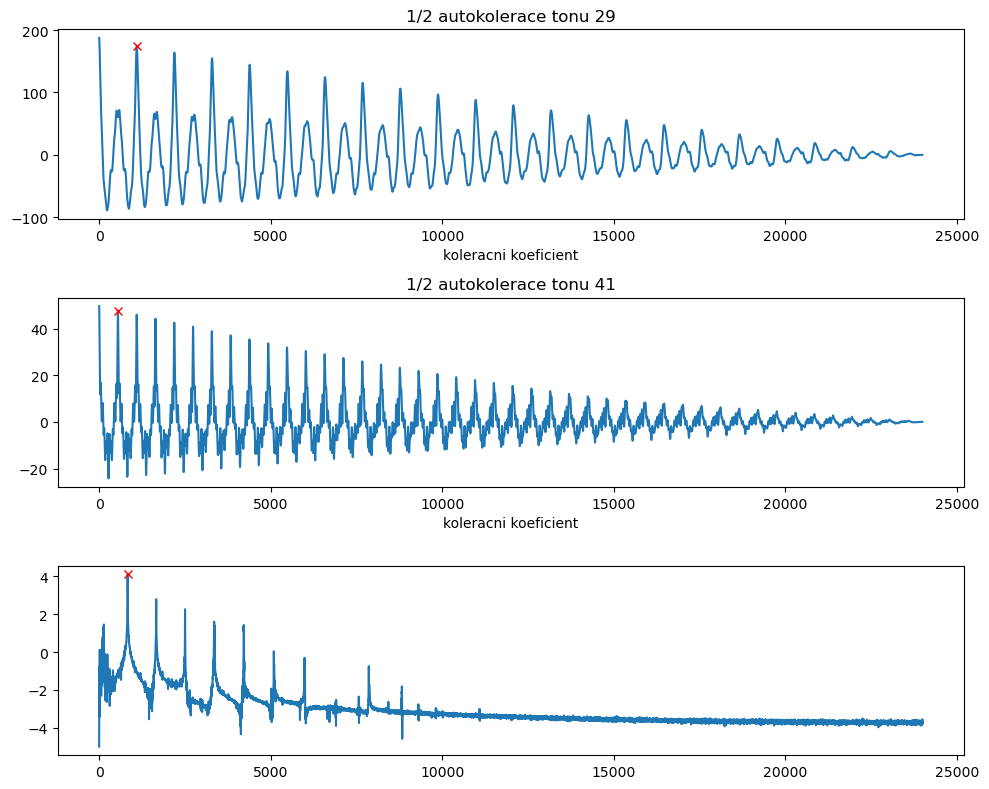

In [77]:
_, ax = plt.subplots(3, 1, figsize=(10, 8))
i = 0
for tone in [29, 41]:
    corr = np.correlate(xall[tone],xall[tone], "full")
    corr = corr[int(len(corr)/2):]
    start = np.argmax(corr<0) 
    peak_max = np.max(corr[start:]) 
    peaks = signal.find_peaks(corr[start:], height=0) 
    peak_distance = peaks[0][np.where(peaks[1]["peak_heights"] == peak_max)[0][0]]
    N = peak_distance + start
    freq = Fs/(N) 
    ax[i].set_title("1/2 autokolerace tonu %d" % tone)
    ax[i].set_xlabel('koleracni koeficient')
    ax[i].plot(corr)
    ax[i].plot(N,corr[N], marker="x", c="r")
    i = i+1

DFT = np.fft.fft(xall[80])
DFT = np.log10((np.abs(DFT)**2) + 1e-5)
DFTHalf = DFT[:DFT.size // 2]
Fk = np.arange(0, DFTHalf.size) * (Fs / (xall[tone].size))
peaks = signal.find_peaks(DFTHalf, height=0) #parameter height vytvori data s hodnotami magnitud
max_mag = np.max(DFTHalf) #zistim najvacsiu hodnotu magnitudy v DFT
fundamental_freq = peaks[0][np.where(peaks[1]["peak_heights"] == max_mag)[0][0]] * 2
ax[2].set_label("DFT tonu 80")
ax[2].plot(Fk, DFTHalf)
ax[2].plot(fundamental_freq, max_mag, marker="x", c="r")
plt.tight_layout()



In [ ]:
e = np.exp(-2j * np.pi * tone_midi_freq / sample_freq)
koeff = np.abs(np.sum(e * tone_signal))